In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm
import quandl
token="QWe8iSbyAFzRuod2aroM"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Dollar turnover

Looks terrible as the data quality is poor


$$  \sum {\text{dvol}_t} $$



In [4]:
dvol=calculate_dollar_volume(cleansed)

tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
tsmom_model.py:35: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:35: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
tsmom_model.py:38: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

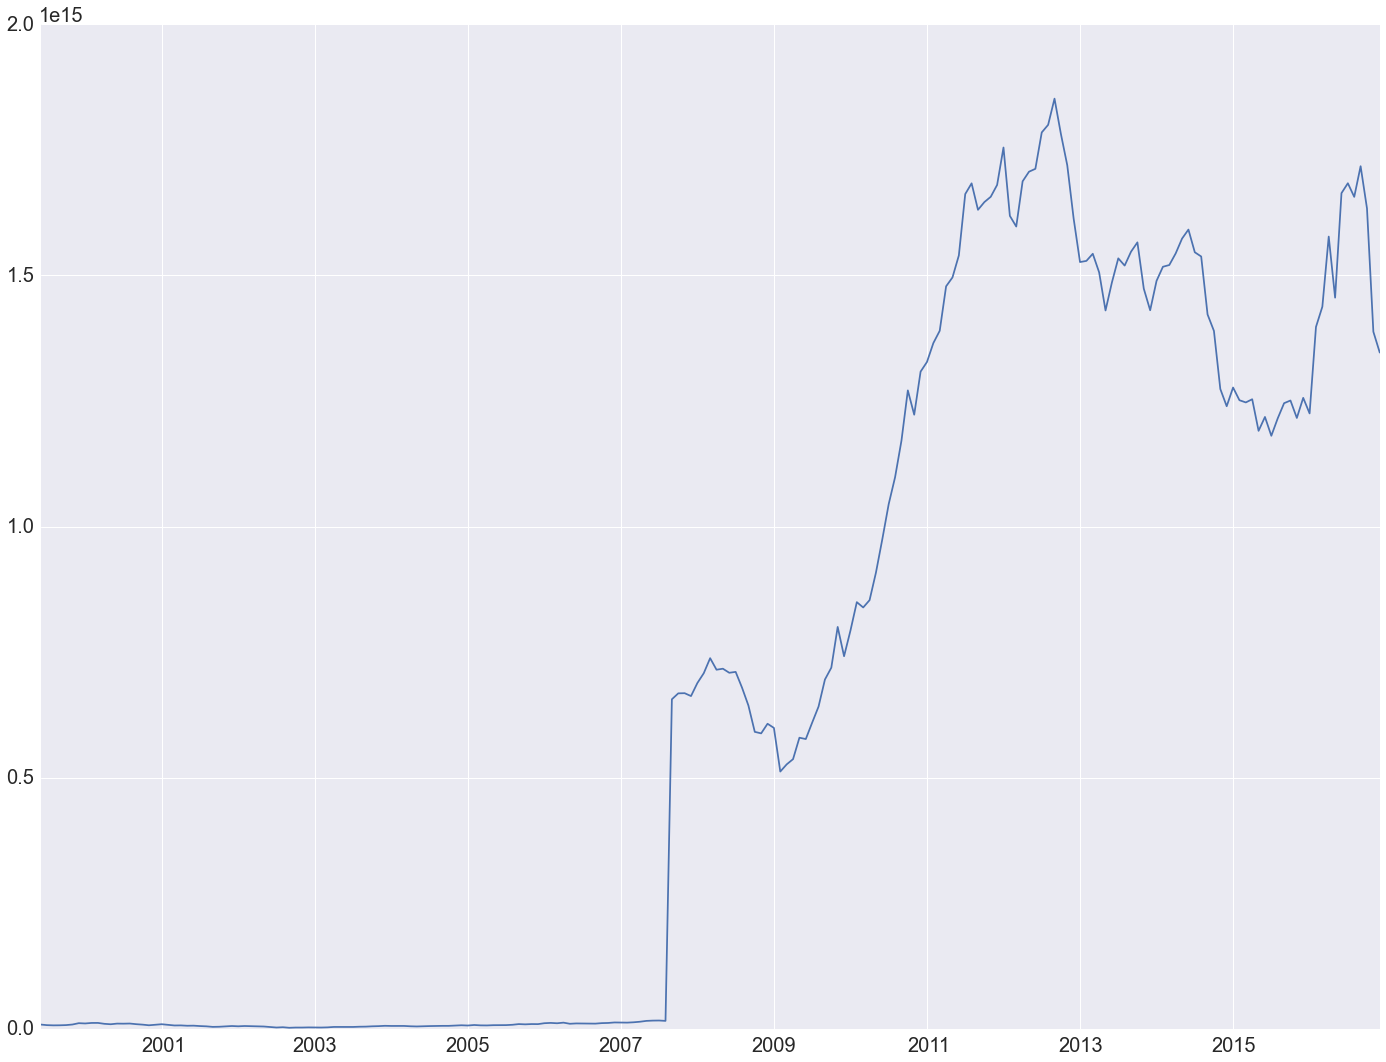

In [5]:
dvol.dropna(how='all').sum(axis=1).plot()

# Funding Rates

* TED spread

In [7]:
ted=quandl.get('FRED/TEDRATE',token=token).Value

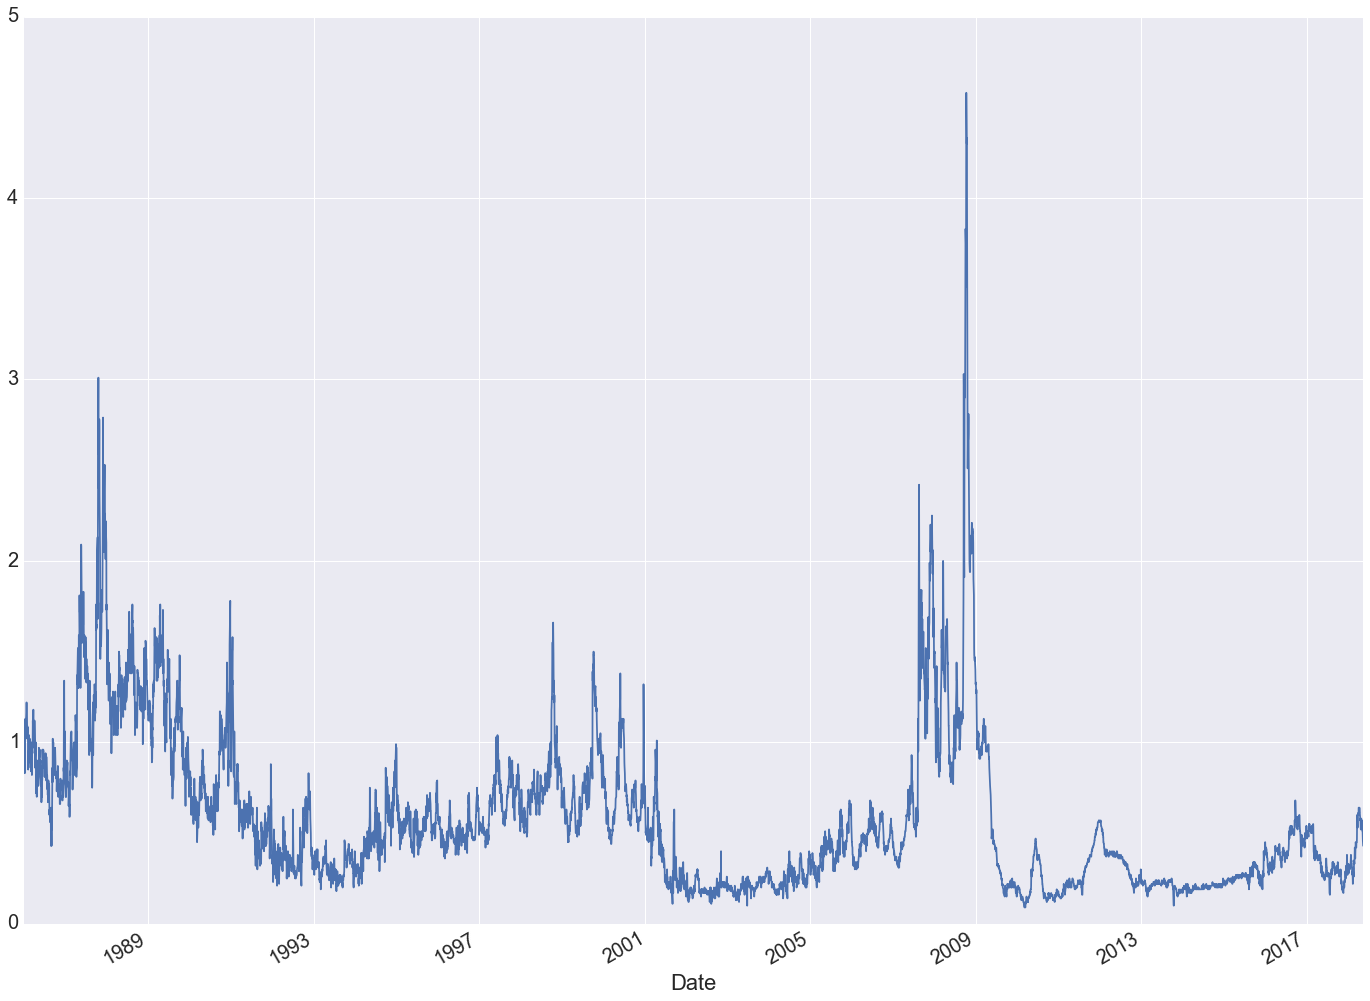

In [8]:
ted.plot()

# Swap versus cash financed

OIS - Tbills

* Missing OIS data

In [9]:
tbill=quandl.get('FRED/DTB3',token=token).Value

# Libor term repo

Overight - Repo rate

* Missing LIBOR O/N rate
* Ticker is FRED/USDONTDIS6N (or something similar)

In [10]:
libor=quandl.get('FRED/USDONTD156N',token=token).VALUE
repo=pd.read_csv('repo.csv',index_col=0,parse_dates=True)
# This needs to get replaced with 
libor_term_repo=(repo.TreasuryRepo-libor).dropna()

# On the run versus off the run 

In [11]:
us10y_zero=quandl.get('FED/SVENY',token=token).SVENY10.resample(rule='d',how='last').dropna()
yield10=quandl.get('USTREASURY/YIELD',token=token)['10 YR'].resample(rule='d',how='last').dropna()
on_off=(us10y_zero-yield10).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


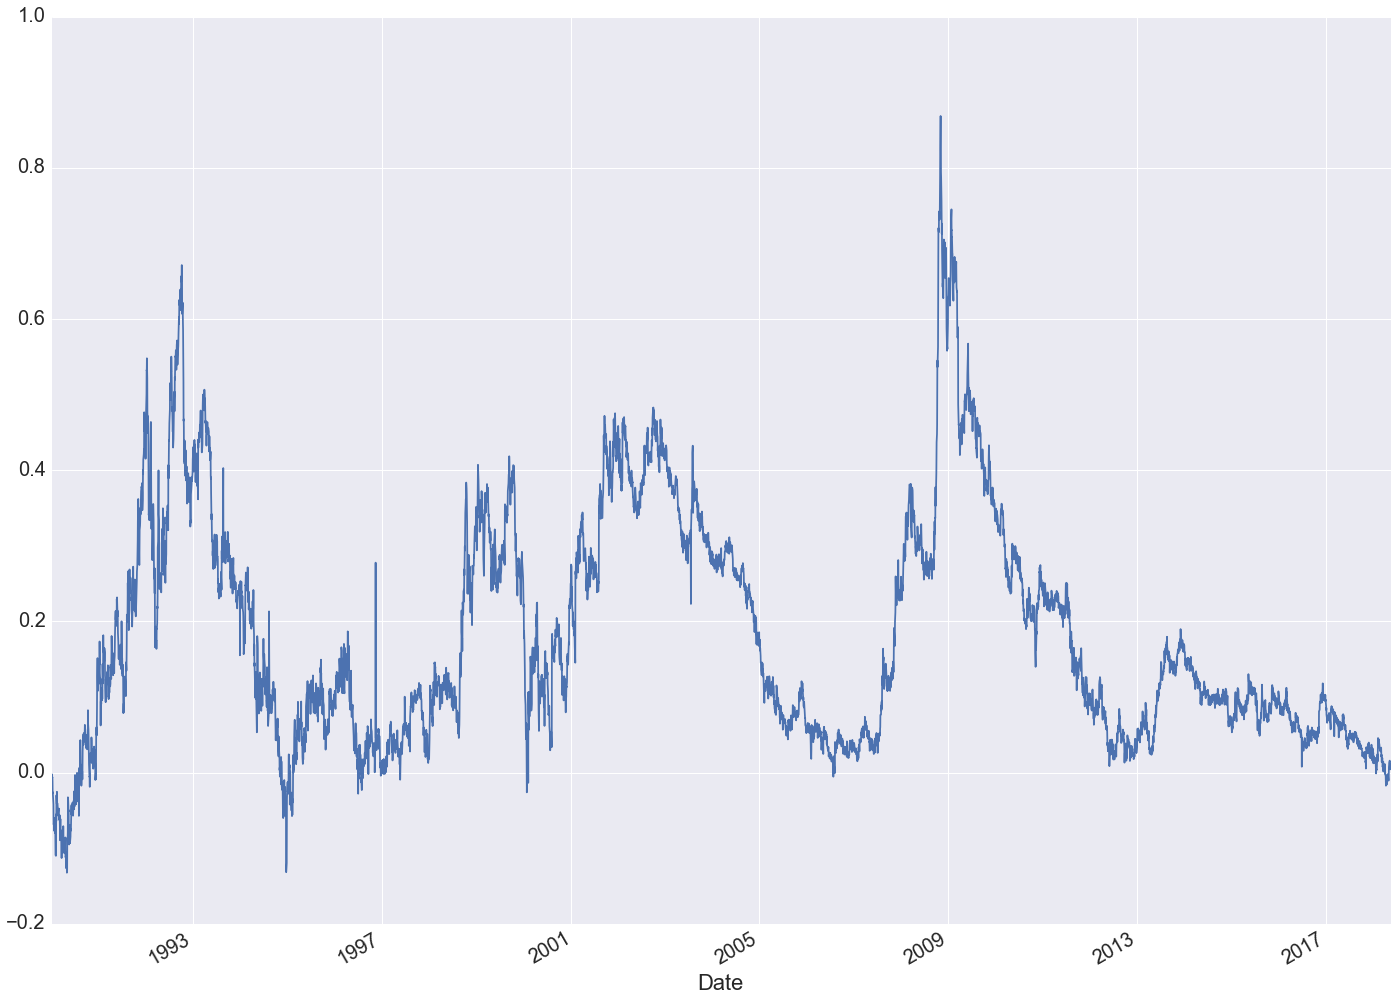

In [12]:
on_off.plot()

# Pastor and Stambagh  (2003)

https://faculty.chicagobooth.edu/lubos.pastor/research/liq_data_1962_2016.txt

In [13]:
PS=pd.read_csv('PS.csv',index_col=0,parse_dates=True).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Getting everything ready for regressions

In [14]:
funding_liquidity = pd.DataFrame()
market_liquidity = pd.DataFrame()
funding_liquidity['TED Spread']=ted.resample(rule='m',how='last')/100.
funding_liquidity['LIBOR term repo']=libor_term_repo.resample(rule='m',how='last')/100.


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


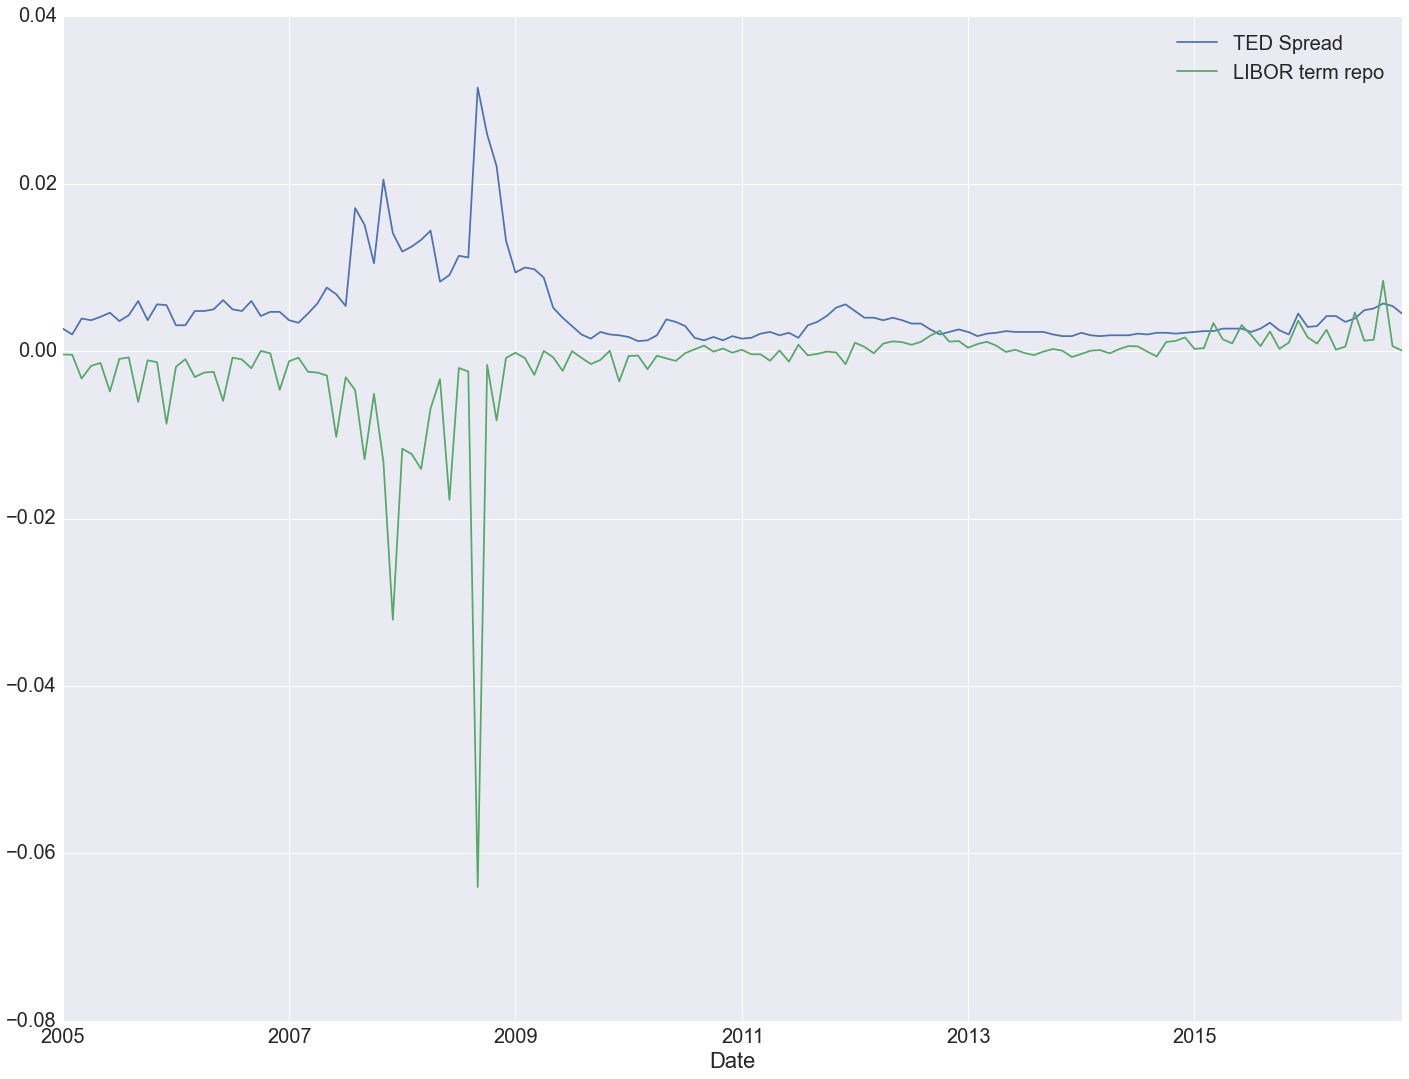

In [15]:
funding_liquidity.dropna().plot()

In [16]:
market_liquidity = pd.DataFrame()
market_liquidity['PS']=PS['Innovations in aggregate liquidity'].resample(rule='m',how='last')
market_liquidity['On versus off the run Treasuries']=on_off.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


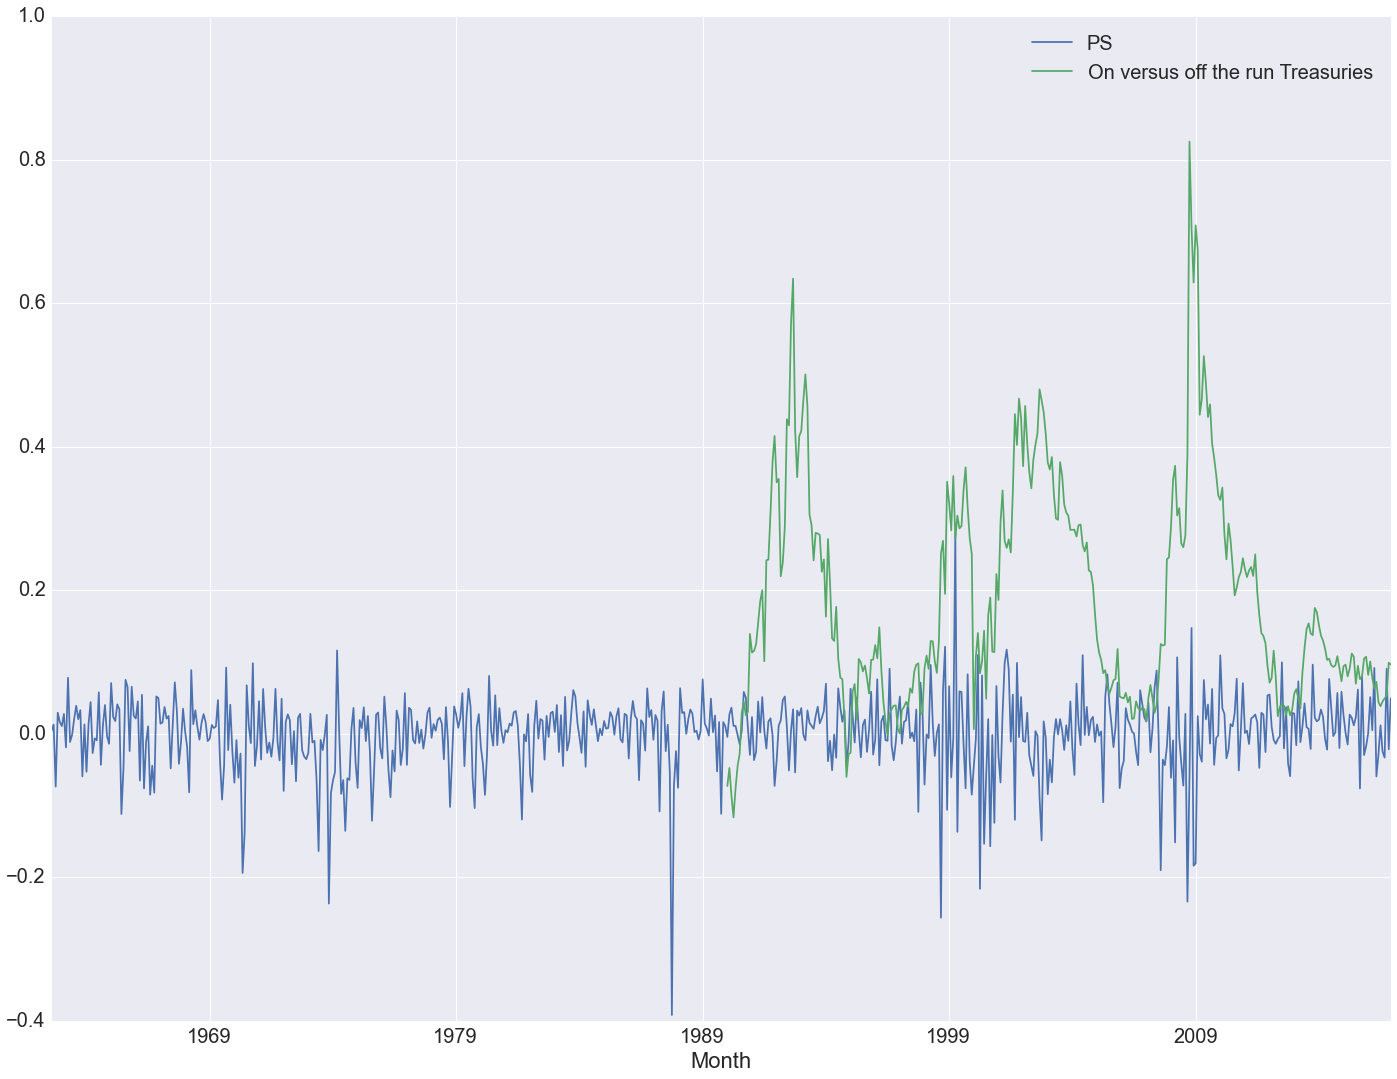

In [17]:
market_liquidity.plot()

# Determinents of Liquidity

In [18]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:49: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

In [19]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [33]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [34]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [43]:
sector_factor.keys()

Index([u'Agriculturals', u'Currencies', u'Energies', u'Equities', u'Metals',
       u'Fixed Income'],
      dtype='object')

In [44]:
sector_factor=pd.DataFrame()
for s in [u'Agriculturals', u'Energies', u'Equities', u'Metals',
       u'Fixed Income']:
    sector_factor[s]=sector_PC[s].mean(axis=1)

# Market Liqudity for Amihud common factors across asset classes




In [51]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind=sector_factor[s].index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [52]:
results_df.T

,0,1,2,3,4
PS,-1.926672,0.220245,4.459550,-2.148651,-1.174503
PSTstats,-1.696490,0.317305,3.084047,-1.566777,-1.018047
On versus off the run Treasuries,0.891682,-0.320692,-4.152885,2.628550,0.886122
On versus off the run TreasuriesTstats,1.414165,-0.917728,-8.566350,4.329517,1.777394


# Funding Liqudity for Amihud common factors across asset classes

Note, since our repo data doesn't go back as long the we only look at it from 2005 to 2016



In [53]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [55]:
results_df.T.round(2)

,Agriculturals,Energies,Equities,Metals,Fixed Income
PS,-1.93,0.22,4.46,-2.15,-1.17
PSTstats,-1.70,0.32,3.08,-1.57,-1.02
On versus off the run Treasuries,0.89,-0.32,-4.15,2.63,0.89
On versus off the run TreasuriesTstats,1.41,-0.92,-8.57,4.33,1.78
TED Spread,43.57,5.12,-113.38,118.73,74.20
TED SpreadTstats,2.32,0.54,-5.24,5.35,3.93
LIBOR term repo,-31.42,2.94,47.95,-54.93,-62.11
LIBOR term repoTstats,-2.91,0.35,3.63,-3.33,-2.68


In [56]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &  Agriculturals &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &          -1.93 &      0.22 &      4.46 &   -2.15 &         -1.17 \\
PSTstats                               &          -1.70 &      0.32 &      3.08 &   -1.57 &         -1.02 \\
On versus off the run Treasuries       &           0.89 &     -0.32 &     -4.15 &    2.63 &          0.89 \\
On versus off the run TreasuriesTstats &           1.41 &     -0.92 &     -8.57 &    4.33 &          1.78 \\
TED Spread                             &          43.57 &      5.12 &   -113.38 &  118.73 &         74.20 \\
TED SpreadTstats                       &           2.32 &      0.54 &     -5.24 &    5.35 &          3.93 \\
LIBOR term repo                        &         -31.42 &      2.94 &     47.95 &  -54.93 &        -62.11 \\
LIBOR term repoTstats                  &          -2.91 &      0.35 &      3.63 &   -3.33 &         -2.68 \\
\bottomrule
\

# Run for unanticipated shocks from residuals from AR(2)

In [26]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [27]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

In [28]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [29]:
results_df.T.round(2)

,Agriculturals,Currencies,Energies,Equities,Metals,Fixed Income
PS,-2.64,-1.33,0.72,2.02,1.18,-1.81
PSTstats,-3.09,-0.52,0.80,0.99,0.83,-1.11
On versus off the run Treasuries,-0.18,-2.25,0.31,1.37,1.28,-2.16
On versus off the run TreasuriesTstats,-0.37,-2.39,0.64,1.48,1.95,-3.22
TED Spread,8.89,34.73,-4.16,-36.45,31.01,17.90
TED SpreadTstats,0.61,0.84,-0.30,-1.89,1.16,0.72
LIBOR term repo,-7.07,-61.91,2.59,20.14,1.34,-18.71
LIBOR term repoTstats,-0.74,-4.99,0.34,2.33,0.08,-1.19


In [30]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &          -2.64 &       -1.33 &      0.72 &      2.02 &    1.18 &         -1.81 \\
PSTstats                               &          -3.09 &       -0.52 &      0.80 &      0.99 &    0.83 &         -1.11 \\
On versus off the run Treasuries       &          -0.18 &       -2.25 &      0.31 &      1.37 &    1.28 &         -2.16 \\
On versus off the run TreasuriesTstats &          -0.37 &       -2.39 &      0.64 &      1.48 &    1.95 &         -3.22 \\
TED Spread                             &           8.89 &       34.73 &     -4.16 &    -36.45 &   31.01 &         17.90 \\
TED SpreadTstats                       &           0.61 &        0.84 &     -0.30 &     -1.89 &    1.16 &          0.72 \\
LIBOR term repo                        &          -7.07 &      -61.91 &      2.59 &     20.14 &    1.34 &        -18.71 \\
LIBOR ter

# FHT method

In [57]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:283: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:284: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:285: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [58]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [59]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [60]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [61]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s].mean(axis=1)

# Market liquidity
TODO: Make errors robus

In [62]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [50]:
results_df.T.round(2)

,0,1,2,3
PS,10.55,16.73,6.17,-8.90
PSTstats,2.35,3.08,2.49,-2.50
On versus off the run Treasuries,-6.84,-8.71,-5.67,6.70
On versus off the run TreasuriesTstats,-3.04,-3.19,-4.19,6.53


In [63]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [64]:
results_df.T.round(2)

,Agriculturals,Currencies,Energies,Equities,Metals,Fixed Income
PS,2.46,1.50,3.09,5.19,2.52,2.89
PSTstats,1.68,1.77,2.16,3.02,1.39,2.43
On versus off the run Treasuries,-1.41,-1.06,-0.09,-2.17,-0.82,-1.21
On versus off the run TreasuriesTstats,-3.06,-3.31,-0.25,-3.87,-1.49,-3.18
TED Spread,-6.30,-25.55,-52.07,-92.47,-75.32,-53.68
TED SpreadTstats,-0.22,-1.50,-1.74,-2.77,-1.96,-2.63
LIBOR term repo,40.69,38.80,71.55,105.55,101.98,67.24
LIBOR term repoTstats,1.88,3.19,3.18,3.55,3.85,4.06


In [65]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  Agriculturals &  Currencies &  Energies &  Equities &  Metals &  Fixed Income \\
\midrule
PS                                     &           2.46 &        1.50 &      3.09 &      5.19 &    2.52 &          2.89 \\
PSTstats                               &           1.68 &        1.77 &      2.16 &      3.02 &    1.39 &          2.43 \\
On versus off the run Treasuries       &          -1.41 &       -1.06 &     -0.09 &     -2.17 &   -0.82 &         -1.21 \\
On versus off the run TreasuriesTstats &          -3.06 &       -3.31 &     -0.25 &     -3.87 &   -1.49 &         -3.18 \\
TED Spread                             &          -6.30 &      -25.55 &    -52.07 &    -92.47 &  -75.32 &        -53.68 \\
TED SpreadTstats                       &          -0.22 &       -1.50 &     -1.74 &     -2.77 &   -1.96 &         -2.63 \\
LIBOR term repo                        &          40.69 &       38.80 &     71.55 &    105.55 &  101.98 &         67.24 \\
LIBOR ter

# Run for unanticipated shocks from residuals from AR(2)


In [61]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [62]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


In [63]:
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [64]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,-0.03,-0.16,4.29,3.36
PSTstats,-0.01,-0.06,0.68,1.28
On versus off the run Treasuries,-3.02,-2.82,-6.26,2.57
On versus off the run TreasuriesTstats,-1.67,-2.44,-2.44,2.20
TED Spread,-81.48,-5.13,-171.35,48.34
TED SpreadTstats,-0.81,-0.09,-1.38,0.77
LIBOR term repo,-55.96,-28.12,7.95,17.43
LIBOR term repoTstats,-1.24,-0.84,0.17,0.54


In [65]:
print results_df.T.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  Commodities &  Equities &  Currencies &  Fixed Income \\
\midrule
PS                                     &        -0.03 &     -0.16 &        4.29 &          3.36 \\
PSTstats                               &        -0.01 &     -0.06 &        0.68 &          1.28 \\
On versus off the run Treasuries       &        -3.02 &     -2.82 &       -6.26 &          2.57 \\
On versus off the run TreasuriesTstats &        -1.67 &     -2.44 &       -2.44 &          2.20 \\
TED Spread                             &       -81.48 &     -5.13 &     -171.35 &         48.34 \\
TED SpreadTstats                       &        -0.81 &     -0.09 &       -1.38 &          0.77 \\
LIBOR term repo                        &       -55.96 &    -28.12 &        7.95 &         17.43 \\
LIBOR term repoTstats                  &        -1.24 &     -0.84 &        0.17 &          0.54 \\
\bottomrule
\end{tabular}

